# 容量制約ありVRPのためのMIPソルバー定式化の性能比較

ここでは、Capacitated Vehicle Routing Problem (CVRP)の異なる定式化を、MIPソルバーを用いて解いたときの性能から比較してみましょう。
CVRPはVRPの一種です。
各顧客には需要があり、車両には容量の制約があります。
CVRPはVRPを一般化したものであり、CVRPの特殊ケースと見なすことができます。  
各モデルをJijModelingを用いて実装し、最適化結果をMINTOで管理、そしてSCIPによりモデルを解いてみましょう。
最後に、各モデルのパフォーマンスを比較します。

## MTZ定式化とフロー定式化

CVRPには主に、MTZ定式化 (ポテンシャル定式化とも呼ばれる) とフロー定式化という2つの定式化があります。

### 各定式化について

MTZ定式化とフロー定式化では、累積需要の追跡の仕方が異なります。
MTZ定式化は各顧客ノードにおける累積需要を追跡するのに対し、フロー定式化は各エッジにおけるフロー量を追跡します。

- MTZ (Miller-Tucker-Zemlin) 定式化:
    MTZ定式化では、各顧客ノードにおける累積需要を表す連続変数を導入し、部分順回路除去制約を表現します。この方法は変数の総数が比較的少なくて済み、モデルも単純です。しかしLP緩和は弱くなります。
- フロー定式化:
    フロー定式化では、各エッジのフロー量を表す連続変数を導入し、フロー保存則を用いて部分巡回路除去制約を表現します。この手法は変数の総数が多くなりますが、LP緩和効果がよりMTZ定式化より極力となります。

それでは、この2つの定式化を実装し、それらの性能を比較してみましょう。

<!-- # Performance Comparison of MIP Solver Formulations for Capacitated VRP

This notebook compares the performance of different formulations for the Capacitated Vehicle Routing Problem (CVRP) using MIP solvers. CVRP is a variant of the Vehicle Routing Problem (VRP) where each customer has a demand and vehicles have capacity constraints. CVRP generalizes VRP, which can be considered as a special case of CVRP.

We implement each model using JijModeling, manage optimization results with MINTO, and solve the models using SCIP. Finally, we compare the performance of each model.

## MTZ formulation and Flow formulation

For CVRP, there are two major formulations: MTZ formulation (also called potential formulation) and Flow formulation.

### About Each Formulation

MTZ formulation and Flow formulation differ in how they track cumulative demand. MTZ formulation tracks cumulative demand at each customer node, while Flow formulation tracks flow amount on each edge. The concept is illustrated in the figure below:

![cvrp_mtz_flow](../../assets/cvrp_mtz_flow.jpg)
*Illustration of `u` and `f` variables in MTZ and Flow formulations. In MTZ formulation, `u` records the vehicle load at each node. In Flow formulation, `f` records the available capacity of vehicles on each edge.*

- MTZ (Miller-Tucker-Zemlin) Formulation:
    MTZ formulation introduces continuous variables representing cumulative demand at each customer node to express subtour elimination constraints. This method has relatively fewer variables and a simpler model but weaker LP relaxation.

- Flow Formulation:
    Flow formulation introduces continuous variables representing flow amount on each edge and uses flow conservation laws to express subtour elimination constraints. This method has more variables but stronger LP relaxation.

Let's implement these two formulations and compare their performance. -->

## CVRP定式化の共通部分の実装

まずは、両方のモデルに共通する部分を実装しましょう。

<!-- ## Common Parts of CVRP Formulation

Let's first implement the parts common to both models. -->

In [9]:
import minto
import jijmodeling as jm
from minto.problems.cvrp import CVRPMTZ, CVRPFlow

## MTZ 定式化

<!-- ## MTZ formulation -->

In [10]:
CVRPMTZ().problem()

## フロー定式化

<!-- ## Flow formulation -->

In [11]:
CVRPFlow().problem()

## ランダムなCVRPインスタンスの生成

モデルのテストを行うために、ランダムなCVRPインスタンスを生成しましょう。

<!-- ## Random CVRP Instance Generation

We generate a random CVRP instance to test the models. -->

In [12]:
n = 10
instance_data = CVRPFlow().random_data(n)
xy = instance_data["xy"]

## パフォーマンス比較

先程作成したランダムCVRPインスタンスを用いて、2つの定式化のパフォーマンスを比較しましょう。
JijModelingを用いた実装を`ommx_pyscipopt_adapter`を用いてPySCIPOptに変換し、SCIPを用いて解きます。
結果はMINTOを用いてロギングします。
`.log_instance`を用いてログに記録する際、後から比較しやすいように各モデルに名前をつけておきましょう。
このチュートリアルでは`auto_saving=False`を設定していますが、実際には自動ログ保存のために`auto_saving=True`を使用することを推奨します。

<!-- ## Performance Comparison

We compare the performance of the two formulations using the random CVRP instance.
The JijModeling implementation is converted to PySCIPOpt using `ommx_pyscipopt_adapter` and solved with SCIP. Results are logged using MINTO.

When logging using `.log_instance`, we assign names to each model to make later comparison easier.

For this tutorial we set `auto_saving=False`, but in practice it is recommended to use `auto_saving=True` for automatic log saving. -->

In [13]:
import time
import ommx_pyscipopt_adapter as scip_ad

exp = minto.Experiment("cvrp", auto_saving=False, verbose_logging=False)

nlist = [8, 9, 10, 11, 12, 13]
for n in nlist:
    print(f"{n=}")
    with exp.run() as run:
        instance_data = CVRPFlow().random_data(n)
        run.log_parameter("n", n)
        intepreter = jm.Interpreter(instance_data)

        # MTZ model
        mtz_instance = intepreter.eval_problem(CVRPMTZ().problem())
        run.log_instance("mtz", mtz_instance)

        adapter = scip_ad.OMMXPySCIPOptAdapter(mtz_instance)
        scip_model = adapter.solver_input

        start = time.time()
        scip_model.optimize()
        scip_model.getStatus()
        elpsed_time = time.time() - start

        run.log_parameter("mtz_time", elpsed_time)

        mtz_solution = adapter.decode(scip_model)
        run.log_solution("mtz", mtz_solution)

        # Flow model
        intepreter = jm.Interpreter(instance_data)
        flow_instance = intepreter.eval_problem(CVRPFlow().problem())
        run.log_instance("flow", flow_instance)

        adapter = scip_ad.OMMXPySCIPOptAdapter(flow_instance)
        scip_model = adapter.solver_input

        start = time.time()
        scip_model.optimize()
        scip_model.getStatus()
        elpsed_time = time.time() - start

        run.log_parameter("flow_time", elpsed_time)

        flow_solution = adapter.decode(scip_model)
        run.log_solution("flow", flow_solution)


n=8
n=9
n=10
n=11
n=12
n=13


In [14]:
exp.get_run_table()

instance_mtz                                                            \
           num_vars num_binary num_integer num_continuous num_cons title name   
run_id                                                                          
0                90         81           0              9     None  None  mtz   
1               110        100           0             10     None  None  mtz   
2               132        121           0             11     None  None  mtz   
3               156        144           0             12     None  None  mtz   
4               182        169           0             13     None  None  mtz   
5               210        196           0             14     None  None  mtz   

       instance_flow                         ... solution_flow             \
            num_vars num_binary num_integer  ...      feasible optimality   
run_id                                       ...                            
0                162         81           0  ...          True          1   
1                200        100           0  ...          True          1   
2                242        121           0  ...          True          1   
3                288        144           0  ...          True          1   
4                338        169           0  ...          True          1   
5                392        196           0  ...          True          1   

                              parameter                       metadata  \
       relaxation start  name         n   mtz_time  flow_time   run_id   
run_id                                                                   
0               0  None  flow         8   0.373916   1.506538        0   
1               0  None  flow         9   1.367615   1.672106        1   
2               0  None  flow        10   0.983179   2.807852        2   
3               0  None  flow        11   1.999751   1.039342        3   
4               0  None  flow        12  67.148398  14.981206        4   
5               0  None  flow        13  28.875992   5.319174        5   

                     
       elapsed_time  
run_id               
0          4.268777  
1          5.526553  
2          6.325906  
3          5.444446  
4         84.476499  
5         36.485040  

[6 rows x 31 columns]

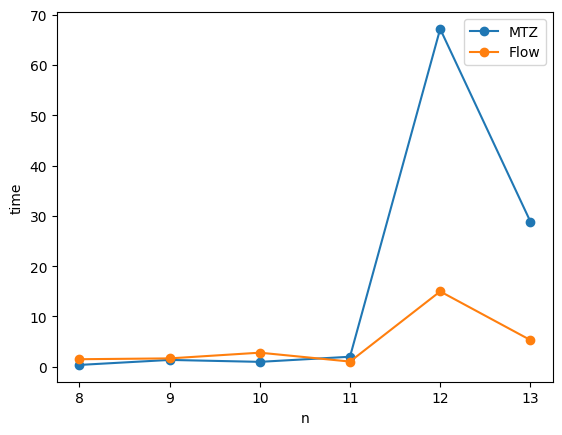

In [15]:
import matplotlib.pyplot as plt

param_table = exp.get_run_table()["parameter"]
plt.plot(param_table["n"], param_table["mtz_time"], "-o", label="MTZ")
plt.plot(param_table["n"], param_table["flow_time"], "-o", label="Flow")
plt.legend()
plt.xlabel("n")
plt.ylabel("time")
plt.show()

## まとめ

ここでは、容量制約あり配送計画問題(CVRP)に対するMTZ定式化とフロー定式化を実装し、ランダムなCVRPインスタンスを用いてそれらの性能を比較しました。
与えられたインスタンスでは、フロー定式化の方がMTZ定式化よりも高速であることがわかりました。  
変数が多いにも関わらず、フロー定式化の方が性能が優れていたのは興味深い点です。
これは分岐限定法の有効性が、制約条件や解が容易に得られるかどうかに依存してどう変化するかを示す良い例となっています。
しかし、性能はインスタンス特性により変化する可能性もあります。
例えば、車両の容量が異なると、結果が大きく異なる可能性もあります。
さらに、MTZ定式化の強化版も利用可能です。  
様々なインスタンス生成方法や強化版のMTZ定式化も、試してみると良いでしょう。

<!-- ## Summary

In this notebook, we implemented MTZ and Flow formulations for the Capacitated Vehicle Routing Problem (CVRP) and compared their performance using a random CVRP instance. We found that the Flow formulation is faster than the MTZ formulation for the given instance.

It is interesting to note that despite having more variables, the Flow formulation performs better. This serves as a good example of how the effectiveness of branch-and-bound methods can vary depending on the constraint conditions and how easy they are to solve.

However, the performance may vary depending on the instance characteristics. For example, different vehicle capacities could lead to significantly different results. Additionally, there are strengthened versions of the MTZ formulation available.

Feel free to experiment with different instance generation methods and strengthened versions of the MTZ formulation. -->